<a href="https://colab.research.google.com/github/AeneasWeiChiHsu/AeneasWeiChiHsu/blob/main/%5BVisual_Cortex%5D_Baseline_Dropout_Triple_Ensemble_Randomized_Contrast_Enhance_Double_Residual_Prioritized_Multi_Step_Double_Dual_Head_DQN_CarRacing_RL_Project_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⚠️ **不要熬夜寫code。**

# Introduction: Double Duel DQN on Car Racing v3

Goal: Average Reward 600+ (more is good) in randomized = True (real test)

Environment: CarRacing-v3 with domain_randomize=True

I adopt a hybrid approach, for more detail, check this one: https://arxiv.org/pdf/1710.02298。

The logic is following: it must work first then we go further.

先求不傷身體再求有療效。

⬆️ DQN (Basic)

⬆️ Dual Head (Q-head: Advanced, Value head -- prevent from overestimate Q-value)

⬆️ Double Network (Model Net + Target Net)

⬆️ Multiple Step Memory (SARSA)

⬆️ Prioritization (Learning from useful experience)

⬆️ Epsilon modification (Adaptive exploration)

⬆️ Reward shaping (Incentive)

⬆️ Residual Connection (Feature engineering)

⬆️ Contrast Enhancement (Inspired by eye)

⬆️ Ensemble (Triple Advantage/Value Network)

⬆️ Training on Randomized Environment (For Generalization)

🧪 Vision Enhancement  (Visual Cortex)

---
I tested the following listed elements, but it does not works well. Perhaps it is due to un-fine-tuned parameters. However, at this stage, for some reasons, I decided not to use them. In future, it is possible to add them back.

⬇️ Q-Distribution (not used) -- I want to remain the duelling structure first.

⬇️ Noisy Net (Unstable)

⬇️ Attention Mechanism (backfire)

> I decide to train an agent to drive because I don't know how to drive.

IBM on Coursera  [Deep Learning with Keras and TensorFlow](https://www.coursera.org/learn/building-deep-learning-models-with-tensorflow/home)

Section [Building a Deep Q-Network with Keras](https://www.coursera.org/learn/building-deep-learning-models-with-tensorflow/ungradedLti/AlszB/lab-building-a-deep-q-network-with-keras)

University of Alberta on Coursera [Fundamentals of Reinforcement Learning](https://www.coursera.org/learn/fundamentals-of-reinforcement-learning/home)


# Goal: Deep Q-Network with Keras

The story started when I took a course called Control Theory — though in practice, it was all about reinforcement learning. At the time, I didn’t understand much. I just wanted to finish the final project: solving the CarRacing environment (v2).

While looking for help, I found a public DualDQN implementation on GitHub. It looked cool, so I tweaked it a little and used it for my project. Technically, it wasn’t my agent that solved the problem — it was someone else’s PyTorch code that did most of the heavy lifting.

But for some reason, I’ve never liked PyTorch. So now, I’m rebuilding the entire thing from scratch — in TensorFlow and Keras, the way I think it should be.

故事是這樣的，我之前上過一門課，叫做《控制理論》，但是內容都是在講 Reinforcement Learning。
不過那個時候我什麼都不懂，只是想要做完期末專題：CarRacing。
所以我在Github上面看到有人 share 了一段 DualDQN 的code，我覺得很棒，我就拿來改。
最後那個不是我的 Agent 幫我完成了我的 Final Project。
不過那段 Code 是用 pytorch 寫的。但是基於某些理由我不喜歡 pytorch。
現在我要做這個 Project。

# Box2D

https://gymnasium.farama.org/environments/box2d/

In [1]:
# Instal Gym
!pip install gymnasium
! pip install swig
! pip install gymnasium[box2d]
# Install OpenCV
!pip install opencv-python

# ==== Note ====
# If you are run it in local jupyter lab, uncomment this line
#!pip install box2d pygame

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from collections import deque
from tensorflow.keras.models import Model

# ==== Layers ====
from tensorflow.keras.layers import Input, InputLayer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, ReLU, MaxPooling2D, UpSampling2D, Concatenate, Activation, Lambda, Add, LayerNormalization, LeakyReLU, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, ZeroPadding2D, Cropping2D, ZeroPadding1D, Cropping1D, Layer, Average, AveragePooling1D

from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization

# ==== Optimizer ====
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl

# ==== Callbacks ====
from tensorflow.keras.callbacks import EarlyStopping

# ==== Saving ====
from keras.saving import register_keras_serializable

# ==== Get File ====
from tensorflow.keras.utils import get_file

In [3]:
from tqdm import tqdm
from tqdm import trange
from collections import Counter

import scipy.stats

# ==== Video ====
import imageio
import os
import cv2 # Import cv2 here

# Environment

https://gymnasium.farama.org/environments/box2d/car_racing/

Actions = [do nothing, left, right, gas, brake]

Observation = **A top-down 96x96 RGB image of the car and race track.**


In [4]:
env = gym.make("CarRacing-v3",
               render_mode= None,
               lap_complete_percent=0.95,
               domain_randomize=False,
               continuous=False)

env.close()

# Model


⬇️ The basic architecute is Duel DQN. Therefore, for each Q-head, we will have two subnet: advanced and value.

Furthermore, I use Stack Frame (RGB). Then the CNN input is 96 x 96 x 12 (for 4 frames)

I use Residual Connect and Constrast Enhancement. I suppose it helps. This idea is inspired by bio-visual system. How you see this world will determine your brain structure.

---
⬇️ My feeling

📦 It is like a box. You never know what you will find inside the box.

📈 OR it is just like a stack.

## Contrast Enhancement

In [5]:
# ==== Nonlinear Contrast Enhancement ====

# ==== Register your layer ====
@register_keras_serializable()

class ContrastEnhance(Layer):
    def __init__(self, alpha=1.5, **kwargs):
        super(ContrastEnhance, self).__init__(**kwargs)
        self.alpha = alpha

    def call(self, x):
        mean = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
        return tf.clip_by_value(self.alpha * (x - mean) + mean, 0.0, 1.0)

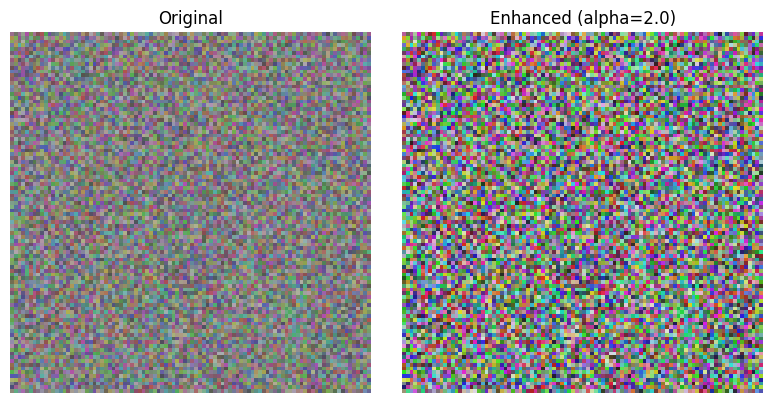

In [6]:
# ==== Visualization of Contrast Enhancement ====
# (batch_size, height, width, channels)
img = tf.random.uniform((1, 96, 96, 3), minval=0.3, maxval=0.7)  # soft grayish noise

# Apply Contrast Enhance
layer = ContrastEnhance(alpha=2.0)
enhanced_img = layer(img)

# ==== Plot Original vs Enhanced ====
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img[0].numpy())
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Enhanced (alpha=2.0)")
plt.imshow(enhanced_img[0].numpy())
plt.axis('off')

plt.tight_layout()
plt.show()

## Dueling Q output

In [7]:
# ==== Dueling Q Output ====

# ==== Register your layer ====
@register_keras_serializable()

def dueling_q_output(x):
    v, a = x
    return v + (a - tf.reduce_mean(a, axis=1, keepdims=True))

## Sober Layer

In [8]:
# ==== Sober ====

# ==== Register your layer ====
@register_keras_serializable()

class SobelEdgeLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Sobel kernels (3x3)
        self.sobel_x = tf.constant([[[-1, 0, 1],
                                     [-2, 0, 2],
                                     [-1, 0, 1]]], dtype=tf.float32)
        self.sobel_y = tf.constant([[[-1, -2, -1],
                                     [ 0,  0,  0],
                                     [ 1,  2,  1]]], dtype=tf.float32)
        self.sobel_45 = tf.constant([[[-2, -1, 0],
                              [-1,  0, 1],
                              [ 0,  1, 2]]], dtype=tf.float32)

        self.sobel_135 = tf.constant([[[ 0, -1, -2],
                               [ 1,  0, -1],
                               [ 2,  1,  0]]], dtype=tf.float32)

    def call(self, x):
        # Input shape: (batch, H, W, C)
        channels = x.shape[-1]
        kernel_x = tf.expand_dims(self.sobel_x, axis=-1)
        kernel_y = tf.expand_dims(self.sobel_y, axis=-1)

        # Repeat for depthwise convolution
        kernel_x = tf.repeat(kernel_x, repeats=channels, axis=-1)
        kernel_y = tf.repeat(kernel_y, repeats=channels, axis=-1)

        kernel_x = tf.reshape(kernel_x, [3, 3, channels, 1])
        kernel_y = tf.reshape(kernel_y, [3, 3, channels, 1])

        # Apply Sobel filters
        gx = tf.nn.depthwise_conv2d(x, kernel_x, strides=[1, 1, 1, 1], padding="SAME")
        gy = tf.nn.depthwise_conv2d(x, kernel_y, strides=[1, 1, 1, 1], padding="SAME")

        grad_magnitude = tf.sqrt(tf.square(gx) + tf.square(gy) + 1e-6)  # 防止 sqrt(0)
        return grad_magnitude

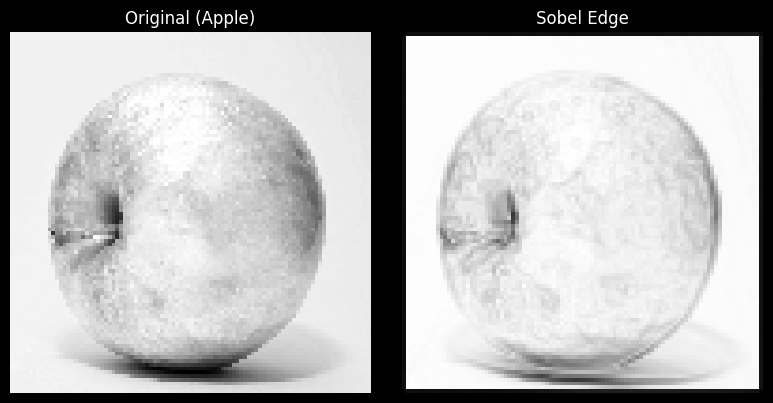

In [31]:
from tensorflow.keras.utils import get_file
# === Load fallback image ===
image_url = "https://upload.wikimedia.org/wikipedia/commons/1/15/Red_Apple.jpg"
image_path = get_file("apple.jpg", origin=image_url)

img_raw = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
img = tf.image.resize(img_raw, [96, 96]) / 255.0
img = tf.expand_dims(img, axis=0)  # (1, 96, 96, 1)

# === Apply Sobel Filter ===
sobel_layer = SobelEdgeLayer()
edges = 1 -  sobel_layer(img) + img

# === Show Result ===
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original (Apple)")
plt.imshow(img[0, ..., 0], cmap = 'gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Sobel Edge")
plt.imshow(edges[0, ..., 0], cmap = 'gray')
plt.axis("off")

plt.tight_layout()
plt.show()

## Q-head

In [10]:
# ==== Q head ====

def build_q_head(x, action_size, head_id=0, use_dropout=False):
    a = Dense(256, activation='relu', name=f'a_{head_id}_dense1')(x)
    a = Dense(128, activation='relu', name=f'a_{head_id}_dense2')(a)
    if use_dropout:
        a = Dropout(0.2, name=f'a_{head_id}_drop')(a)
    a = Dense(action_size, name=f'a_{head_id}_out')(a)

    v = Dense(256, activation='relu', name=f'v_{head_id}_dense1')(x)
    v = Dense(128, name=f'v_{head_id}_dense2')(v)
    if use_dropout:
        v = Dropout(0.2, name=f'v_{head_id}_drop')(v)
    v = Dense(1, name=f'v_{head_id}_out')(v)

    q = Lambda(dueling_q_output, name=f'q_{head_id}')([v, a])
    return q

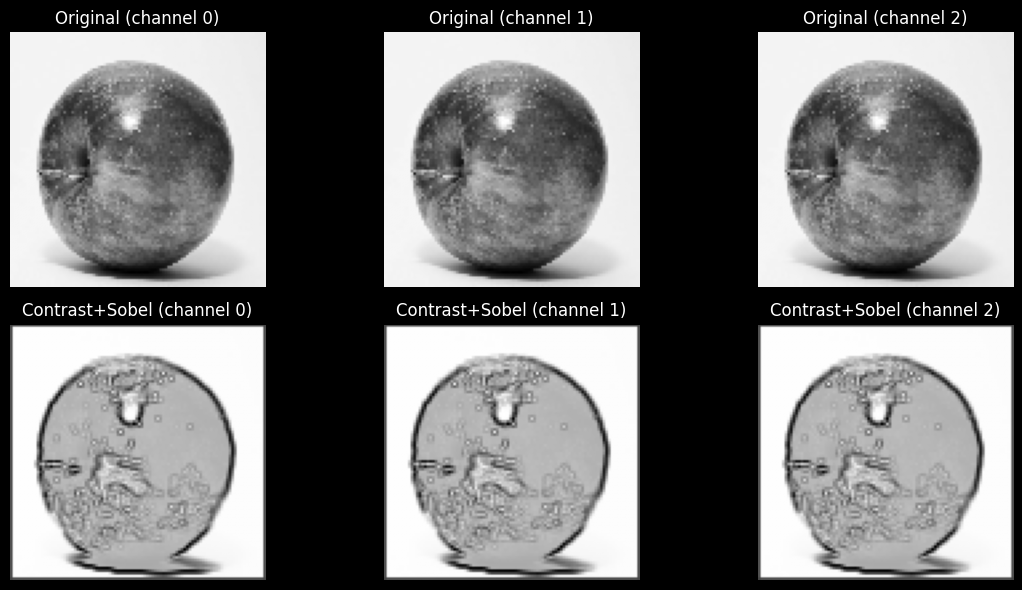

In [44]:
# === Apple Image ===
apple_path = tf.keras.utils.get_file("apple.jpg", "https://upload.wikimedia.org/wikipedia/commons/1/15/Red_Apple.jpg")

# To Gray + resize
image = tf.image.decode_jpeg(tf.io.read_file(apple_path), channels=3)
image = tf.image.rgb_to_grayscale(image)
image = tf.image.resize(image, [96, 96]) / 255.0
image = tf.expand_dims(image, axis=0)  # shape = (1, 96, 96, 1)

# Sent to Conv2D
image = tf.repeat(image, repeats=8, axis=-1)  # shape = (1, 96, 96, 8)

# === Test Layer  ===
residual = image  # Preserve original input
x = ContrastEnhance(alpha=2.0)(image)

x = ContrastEnhance(alpha=2.0)(x)

x = 1 - SobelEdgeLayer()(x) + x


x = tf.keras.layers.Add()([x, residual])  # Residual short cut
#x = tf.clip_by_value(x, 0.0, 1.0)

plt.figure(figsize=(12, 6))
for i in range(3):
    # Original
    plt.subplot(2, 3, i + 1)
    plt.title(f"Original (channel {i})")
    plt.imshow(image[0, :, :, i].numpy(), cmap='gray')
    plt.axis("off")

    # Processed
    plt.subplot(2, 3, i + 4)
    plt.title(f"Contrast+Sobel (channel {i})")
    plt.imshow(x[0, :, :, i].numpy(), cmap='gray')
    plt.axis("off")

plt.tight_layout()
plt.show()

## Main Model

In [12]:
# ==== Build Model ====
# If you use stack frame, the input is (96, 96, 12)
# If you don't use stack frame, the input is (96, 96, 3)
def build_model (input_shape = (96, 96, 12), action_size = 5):
  inputs = Input(shape = input_shape) # (96, 96, 12)

  # Normalize pixel [0,255] → [0,1]
  x = tf.keras.layers.Rescaling(1./255)(inputs) # (96, 96, 12)

  # ==== Gray ====
  x = Conv2D(8, (1, 1), activation='relu')(x)  # (96, 96, 8)


  # ==== Visual Cortex ====
  # ==== Experimental ====

  # ==== Residual ====
  #residual0 = x # (96, 96, 8)

  # ==== Contrast Enhancement ====
  # ==== Recommended =====
  x = ContrastEnhance(alpha=2.0)(x) # (96, 96, 8)
  x = ContrastEnhance(alpha=2.0)(x) # (96, 96, 8)

  # ==== Sober Edge Layer ====
  #x = SobelEdgeLayer()(x) # (96, 96, 8)

  #x = Add()([x, residual0]) # (96, 96, 8)

  # ==== Convolution Backbone ====

  # ==== Convolution Layers ====
  x = Conv2D(16, (8, 8), strides=4, activation = None)(x) # (23, 23, 16)
  x = ReLU()(x) # You can try ReLU or LeakyReLU

  # ==== Residual  1 ====
  residual1 = x # (23, 23, 16)

  x = Conv2D(16, (3, 3), strides=1, activation = None, padding = 'same')(x) # (23, 23, 16) because padding = 'same'
  x = ReLU()(x)
  x = Conv2D(16, (3, 3), strides=1, activation = None, padding = 'same')(x) # (23, 23, 16) because padding = 'same'

  x = Add()([x, residual1]) # (23, 23, 16)
  x = ReLU()(x)
  # ==== Residual 1 ==== End

  # Input 23 → (23 - 4)/2 + 1 = 10
  x = Conv2D(32, (4, 4), strides=2, activation = None)(x)
  x = ReLU()(x)

  # ==== Residual 2 ====

  # ==== Residual Block after downsample ====
  residual2 = x  # Save shortcut: (10, 10, 32)

  x = Conv2D(32, (3, 3), strides=1, padding='same', activation=None)(x)
  x = ReLU()(x)
  x = Conv2D(32, (3, 3), strides=1, padding='same', activation=None)(x)

  x = Add()([x, residual2])
  x = ReLU()(x)
  # ==== Residual 2 ===== End

  # Input 10 → (10 - 3)/1 + 1 = 8
  x = Conv2D(64, (3, 3), strides=1, activation = None)(x)
  x = ReLU()(x)

  # Input 8 → (8 - 3)/1 + 1 = 6
  x = Conv2D(128, (3, 3), strides=1, activation = None)(x)
  x = ReLU()(x)

  # ==== Flaten ====
  x = Flatten()(x)
  #x = GlobalAveragePooling2D()(x)

  # ==== Deep Layers ====
  x = Dense(512, activation='relu')(x)

  x = Dense(256, activation='relu')(x)

  x = Dense(128, activation='relu')(x)

  x = Dense(64, activation='relu')(x)

  # ==== Dueling DQN =====
  # Two head mechanism
  # Advantage Stream
  #a = Dense(256, activation= 'relu')(x)
  #a = NoisyDense(128, sigma_init=0.05)(a)
  #a = Dense(action_size)(a)


  # Value Stream
  #v = Dense(256, activation = 'relu')(x)
  #v = Dense(128)(v)
  #v = Dense(1)(v)

  # ==== Ensemble Dueling DQN ====
  # ==== Ensemble Dueling DQN ====
  # === Q-head #1 ===
  a1 = Dense(256)(x)
  a1 = Dense(128, activation='relu')(a1)
  a1 = Dense(action_size)(a1)

  v1 = Dense(256, activation='relu')(x)
  v1 = Dense(128)(v1)
  v1 = Dense(1)(v1)

  q1 = Lambda(dueling_q_output)([v1, a1])

  # === Q-head #2  ===
  a2 = Dense(256, activation='relu')(x)
  a2 = Dense(128, activation='relu')(a2)
  a2 = Dense(action_size)(a2)

  v2 = Dense(256, activation='relu')(x)
  v2 = Dense(128, activation='relu')(v2)
  v2 = Dropout(0.2)(v2)
  v2 = Dense(1)(v2)

  q2 = Lambda(dueling_q_output)([v2, a2])

  # === Q-head #3
  a3 = Dense(256, activation='relu')(x)
  a3 = Dense(128, activation='relu')(a3)
  a3 = Dropout(0.2)(a3)
  a3 = Dense(action_size)(a3)

  v3 = Dense(256, activation='relu')(x)
  v3 = Dense(128, activation='relu')(v3)
  v3 = Dense(1)(v3)

  q3 = Lambda(dueling_q_output)([v3, a3])

  # ==== Output ====
  # Q-values for each discrete action
  # Output: q_values = [[12.3, 11.8, 9.5, 14.2, 13.0]]
  # The q_values of each action
  # i.e., Q(s, a = 0) = 12.3
  # i.e., Q(s, a =1) = 11.8
  #outputs = Dense(action_size, activation='linear', name = 'Q-values')(x)

  # ==== Dueling DQN Output ====
  # Q(s, a) = V(s) + (A(s, a) - mean(A(s, a')))
  # V(s) -> (batch_size, 1)
  # A(s, a) -> (batch_size, action_size)

  # ==== Output ====
  # Note: Remember add "output_shape = (None, action_size)"
  #outputs = Lambda(dueling_q_output, output_shape=(action_size,))([v, a])

  # === Combine ===
  q_mean = Average()([q1, q2, q3])

  outputs = q_mean

  # ==== Model Build ====
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer=Adam(learning_rate=0.00025), loss='huber')

  return model

# ==== Car Racing parameters ====
state_size = 96*96*12
action_size = 5

# ==== Structure ====
test_model = build_model(input_shape = (96, 96, 12), action_size = 5)
test_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96,    │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 96, 96,    │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 96, 8) │        104 │ rescaling[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contrast_enhance_3  │ (None, 96, 96, 8) │          0 │ conv2d[0][0]      │
│ (ContrastEnhance)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contrast_enhance_4  │ (None, 96, 96, 8) │          0 │ contrast_enhance… │
│ (ContrastEnhance)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sobel_edge_layer_2  │ (None, 96, 96, 8) │          0 │ contrast_enhance… │
│ (SobelEdgeLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 96, 96, 8) │          0 │ sobel_edge_layer… │
│                     │                   │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 23, 23,    │      8,208 │ add_1[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 23, 23,    │          0 │ conv2d_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 23, 23,    │      2,320 │ re_lu[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 23, 23,    │          0 │ conv2d_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 23, 23,    │      2,320 │ re_lu_1[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 23, 23,    │          0 │ conv2d_3[0][0],   │
│                     │ 16)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 23, 23,    │          0 │ add_2[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 10, 10,    │      8,224 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 10, 10,    │          0 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 10, 10,    │      9,248 │ re_lu_3[0][0]     │
│                     │ 32)               │            │                 

 Total params: 2,963,850 (11.31 MB)

 Trainable params: 2,963,850 (11.31 MB)

 Non-trainable params: 0 (0.00 B)

# Implement the replay buffer (Memory)

⬇️ Memory

For single step memory:

It is just a note.


```
memory = deque(maxlen=10000)
def remember(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))
```




## SumTree

In [13]:
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)  # binary tree
        self.data = np.zeros(capacity, dtype=object)  # actual data
        self.write = 0
        self.n_entries = 0

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2
        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, priority, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, priority)
        #print(f"Added to tree_idx={idx}, priority={priority}, data={data}")
        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        self.n_entries = min(self.n_entries + 1, self.capacity)

    def update(self, idx, priority):
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        data_idx = idx - self.capacity + 1
        return (idx, self.tree[idx], self.data[data_idx])

In [14]:
# ==== Sum Tree Test Cell ====
tree = SumTree(capacity=5)

# Insert 5 data with different priority priority
for i in range(5):
    priority = (i + 1) * 10  # 10, 20, ..., 50
    data = f"data_{i}"
    tree.add(priority, data)
    print(f"✅ Added {data} with priority {priority}")

print("\n🌳 Tree total priority:", tree.total())  # 10 + 20 + 30 + 40 + 50 = 150

# Use get() to simulate 0 ~ total() sampling
print("\n🎯 Sampling test:")
for s in [5, 15, 35, 75, 125]:
    idx, p, data = tree.get(s)
    print(f"s={s:>3} → index={idx}, priority={p}, data={data}")

✅ Added data_0 with priority 10
✅ Added data_1 with priority 20
✅ Added data_2 with priority 30
✅ Added data_3 with priority 40
✅ Added data_4 with priority 50

🌳 Tree total priority: 150.0

🎯 Sampling test:
s=  5 → index=7, priority=40.0, data=data_3
s= 15 → index=7, priority=40.0, data=data_3
s= 35 → index=7, priority=40.0, data=data_3
s= 75 → index=8, priority=50.0, data=data_4
s=125 → index=6, priority=30.0, data=data_2


In [15]:
# ==== Test Sum Tree ====
tree = SumTree(capacity=5)

# Add 5 items
for i in range(5):
    tree.add(priority=(i + 1) * 10, data=f"data_{i}")  # Priorities: 10, 20, ..., 50

print(f"🌳 Initial total: {tree.total()}")  # Expect 150

# === Test update ===
# Let's update index 7 (data_3) to a new priority = 100
tree_idx = 7
tree.update(tree_idx, 100)

# Check tree total
print(f"🌳 After update total: {tree.total()}")  # Expect: 150 - 40 + 100 = 210

# === Sampling ===
print("\n🎯 Sampling after update:")
for s in [5, 15, 45, 105, 175]:
    idx, priority, data = tree.get(s)
    print(f"s={s:<3} → index={idx}, priority={priority}, data={data}")

🌳 Initial total: 150.0
🌳 After update total: 210.0

🎯 Sampling after update:
s=5   → index=7, priority=100.0, data=data_3
s=15  → index=7, priority=100.0, data=data_3
s=45  → index=7, priority=100.0, data=data_3
s=105 → index=8, priority=50.0, data=data_4
s=175 → index=5, priority=20.0, data=data_1


##Prioritized Multiple Step Replay Buffer

In [16]:
class PrioritizedMultiStepReplayBuffer:
    def __init__(self, capacity=100000, n_step=5, gamma=0.99):
        self.tree = SumTree(capacity)  # ← Replace deque
        self.capacity = capacity
        self.n_step = n_step
        self.gamma = gamma
        self.n_step_buffer = deque(maxlen=n_step)
        self.max_priority = 1.0  # Initialize: Prevent all priority = 0

    def store(self, state, action, reward, next_state, done):
    # Add n-step buffer
        self.n_step_buffer.append((state, action, reward, next_state, done))

        # If it reaches n step, process real transition
        if len(self.n_step_buffer) == self.n_step:
            s, a, _, _, _ = self.n_step_buffer[0]
            R, s_n, done_n = self._compute_n_step_return()
            transition = (s, a, R, s_n, done_n)
            self.tree.add(self.max_priority, transition)
            self.n_step_buffer.popleft()

        # If episode is done, clear
        if done:
            while len(self.n_step_buffer) > 0:
                s, a, _, _, _ = self.n_step_buffer[0]
                R, s_n, done_n = self._compute_n_step_return()
                transition = (s, a, R, s_n, done_n)
                self.tree.add(self.max_priority, transition)
                self.n_step_buffer.popleft()

    def _compute_n_step_return(self):
        R = 0
        for idx, (_, _, r, _, d) in enumerate(self.n_step_buffer):
            R += (self.gamma ** idx) * r
            if d:
                break
        s_n = self.n_step_buffer[idx][3]
        done_n = self.n_step_buffer[idx][4]
        return R, s_n, done_n

    def sample(self, batch_size, beta=0.4):
        indices = []
        priorities = []
        transitions = []

        # Total priority
        total = self.tree.total()
        if total == 0:
          raise ValueError("Cannot sample from an empty SumTree with total priority 0.")

        # Segment
        segment = total / batch_size

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = np.random.uniform(a, b)  # Uniform sampling in [a, b]
            idx, p, data = self.tree.get(s)
            priorities.append(p)
            transitions.append(data)
            indices.append(idx)

        # normalize IS weights
        probs = np.array(priorities) / total
        weights = (self.tree.n_entries * probs) ** (-beta)
        weights /= weights.max()  # normalize

        # Unpack batch
        states, actions, rewards, next_states, dones = zip(*transitions)

        # Check your output
        return (
            np.array(states), # 1
            np.array(actions), # 2
            np.array(rewards, dtype=np.float32), # 3
            np.array(next_states), # 4
            np.array(dones, dtype=np.float32), # 5
            np.array(indices), # 6
            np.array(weights, dtype=np.float32) # 7
        )
    def __len__(self):
      return self.tree.n_entries

    def clear(self):
      self.tree = SumTree(self.tree.capacity)  # Build a new SumTree
      self.n_step_buffer.clear()               # Clear multi-step buffer

    def update_priorities(self, indices, new_priorities):
      for idx, priority in zip(indices, new_priorities):
          epsilon = 1e-6
          priority = np.clip(priority, epsilon, None) # 👈 Prevent priority becomes 0
          self.tree.update(idx, priority) # 👈 Sent back to SumTree
          self.max_priority = max(self.max_priority, priority) # 👈 Remain max for new transition


## Multiple Step Replay Buffer

In [17]:
class MultiStepReplayBuffer:
    def __init__(self, capacity=100000, n_step=5, gamma=0.99):
        self.buffer = deque(maxlen=capacity)
        self.n_step = n_step
        self.gamma = gamma
        self.n_step_buffer = deque(maxlen=n_step)

    def store(self, state, action, reward, next_state, done):
        self.n_step_buffer.append((state, action, reward, next_state, done))
        if len(self.n_step_buffer) == self.n_step:
            s, a, _, _, _ = self.n_step_buffer[0]
            R, s_n, done_n = self._compute_n_step_return()
            self.buffer.append((s, a, R, s_n, done_n))
        if done:
            while len(self.n_step_buffer) > 0:
                s, a, _, _, _ = self.n_step_buffer[0]
                R, s_n, done_n = self._compute_n_step_return()
                self.buffer.append((s, a, R, s_n, done_n))
                self.n_step_buffer.popleft()

    def _compute_n_step_return(self):
        R = 0
        for idx, (_, _, r, _, d) in enumerate(self.n_step_buffer):
            R += (self.gamma ** idx) * r
            if d: break
        s_n = self.n_step_buffer[idx][3]
        done_n = self.n_step_buffer[idx][4]
        return R, s_n, done_n

    def sample(self, batch_size):
        import random
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        # Check your output
        return (
                np.array(states),  # 1
                np.array(actions),  # 2
                np.array(rewards),  # 3
                np.array(next_states), # 4
                np.array(dones) # 5
              )

    def __len__(self):
        return len(self.buffer)

    def clear(self):
        self.buffer.clear()
        self.n_step_buffer.clear()

In [18]:
# ==== Test Buffer ====
# ====  Dummy Data ====
state = np.zeros((96, 96, 12), dtype=np.uint8)
next_state = np.ones((96, 96, 12), dtype=np.uint8)

# Initialize buffer
buffer = PrioritizedMultiStepReplayBuffer(capacity=10, n_step=3, gamma=0.99)

# ==== TEST 1: Sent n-step transitions ====
for i in range(5):
    s = state + i  # Change state
    ns = next_state + i
    buffer.store(s, i % 5, 1.0 + i, ns, done=False)
buffer.store(s, 0, 0.5, ns, done=True)  # suppose episode ends

print(f"✅ Buffer length after insert: {len(buffer)}")
print(f"✅ Tree total priority: {buffer.tree.total():.2f}")

# ==== TEST 2: sample transitions ====
sampled = buffer.sample(batch_size=3)
states, actions, rewards, next_states, dones, indices, weights = sampled

print(f"\n🎯 Sampled actions: {actions}")
print(f"🎯 Sampled indices: {indices}")
print(f"🎯 Importance weights: {weights.round(4)}")

# ==== TEST 3: update priority ====
new_priorities = np.random.uniform(0.1, 5.0, size=3)
print(f"\n📦 New priorities: {new_priorities.round(2)}")
buffer.update_priorities(indices, new_priorities)

print(f"✅ Updated tree total priority: {buffer.tree.total():.2f}")

✅ Buffer length after insert: 6
✅ Tree total priority: 6.00

🎯 Sampled actions: [0 2 4]
🎯 Sampled indices: [ 9 11 13]
🎯 Importance weights: [1. 1. 1.]

📦 New priorities: [3.84 2.13 2.03]
✅ Updated tree total priority: 11.00


# Epsilon Greedy Policy (Act)

➡️ epsilon control

我們進行所謂的 exploration - exploitation trade-off

這裡我們要進行 epsilon 的微調。

我試過的策略包括了：

定義 acton 的時候微調 epsilon。讓 rewards per episode 大於 300 的時候增加 agent 對環境的探索。
目標是克服 reward plateau。
最後的結果是在後期的training的時候變得比較穩定一些。


In [19]:
# ==== Epsilon-greedy Parameters ====
# exploration rate
epsilon = 1.0
# minimum exploration rate
epsilon_min = 0.01
# dacay rate for epsilon after each episode
epsilon_decay =100000 # 10000

epsilon_start = 1.0
epsilon_end = 0.05

total_steps = 0

# ==== Action ====
# act(): chooses an action based on the epsilon-greedy policy.
# ==== Action Selection ====
def act(state, use_epsilon):
    global epsilon

    if use_epsilon:
      if np.random.rand() < epsilon:
          return np.random.choice(action_size)  # Randomly select an action

    q_values = model.predict(state[np.newaxis, ...], verbose=0)
    return np.argmax(q_values[0])

# ==== Decay epsilon ====
def decay_epsilon(total_steps, episode):
    global epsilon

    epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * total_steps / epsilon_decay)

# Double DQN Replay

In [20]:
@tf.function

# ==== Training Step ====
def train_step(states, target_qs, weights):

    with tf.GradientTape() as tape:
        q_pred = model(states, training=True)
        elementwise_loss = tf.keras.losses.Huber(reduction='none')(target_qs, q_pred)
        loss = tf.reduce_mean(elementwise_loss * weights)  # ← IS weighting
    grads = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

# ==== Double Replay ====
def double_replay(batch_size, episode):
  global epsilon, steps

  # === Safe Sample ===
  sampled = memory.sample(batch_size)

  if isinstance(memory, PrioritizedMultiStepReplayBuffer):
      states, actions, rewards, next_states, dones, indices, weights = sampled
  else:
      states, actions, rewards, next_states, dones = sampled
      indices = None
      weights = np.ones_like(rewards)

  # ==== Debug shape ====
  if states.shape != (batch_size, 96, 96, 12):
      print(f"⚠️ [Episode {episode}] Sample shape mismatch: {states.shape}")
      return

  # ==== Check ====
  if states.shape != (batch_size, 96, 96, 12):
    print(f"❌ Shape mismatch: got {states.shape}, skipping training")
    return

  # ==== Double DQN target ====
  next_q_main = model.predict(next_states, verbose=0)
  # Predict next Q-values using main model (for action selection)
  next_actions = np.argmax(next_q_main, axis=1)
  # Predict next Q-values using target model (for evaluation)
  next_q_target = target_model.predict(next_states, verbose=0)

  # ==== Get current Q values ====
  q_values = model.predict(states, verbose=0)

  # ==== TD error ====
  td_errors = []

  for i in range(batch_size):
      target = rewards[i] if dones[i] else rewards[i] + gamma * next_q_target[i][next_actions[i]]
      td_error = abs(target - q_values[i][actions[i]])  # ← TD error
      td_errors.append(td_error)
      q_values[i][actions[i]] = target

  # Train on updated Q-values
  # Call the tf.function-wrapped training step
  # ==== Training Step ====
  train_step(
    tf.convert_to_tensor(states, dtype=tf.float32),
    tf.convert_to_tensor(q_values, dtype=tf.float32),
    tf.convert_to_tensor(weights[:, None], dtype=tf.float32),  # 👈 shape=(batch_size, 1)
  )

  # ==== Update Priorities ====
  if indices is not None:
    memory.update_priorities(indices, td_errors)

# Training Loop 主要訓練迴圈

### Frame Stack

In [21]:
# ==== Frame Stack ====
# Initialize buffer
NUM_FRAMES = 4
frame_buffer = deque(maxlen=NUM_FRAMES)

def preprocess_frame(frame, size=(96, 96), grayscale=False):
    if grayscale:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, size)
        frame = np.expand_dims(frame, axis=-1)  # (96,96,1)
    else:
        frame = cv2.resize(frame, size)  # RGB
    return frame.astype(np.uint8)

### Shaping reward

In [22]:
def reward_shaping(action, reward, next_state=None, info=None):
  shaped_reward = float(reward)

  # Punish stay
  if action == 0:
    shaped_reward -= 0.1  # 懲罰原地不動
  elif action == 3:  # 加速
      shaped_reward += 0.00
  elif action in [1, 2]:  # 轉彎
      shaped_reward += 0.00
  elif action == 4:  # 減速
      shaped_reward -= 0.00

  return shaped_reward

# ==== How to Use ====
# In training loop:
# for each episode:
# reward = shaped_reward(action)

## Display

In [23]:
# ==== Display ====
from IPython.display import clear_output
import matplotlib.pyplot as plt
def plot_training_progress(rewards, smoothing=0.9):
    # ==== Smooth ====
    def smooth(data, weight):
        smoothed = []
        last = data[0]
        for point in data:
            smoothed_val = last * weight + (1 - weight) * point
            smoothed.append(smoothed_val)
            last = smoothed_val
        return smoothed

      # ==== Moving Std====
    def moving_std(data, window=20):
        return [np.std(data[max(0, i - window):i + 1]) for i in range(len(data))]


    smoothed_rewards = smooth(rewards, smoothing)

    std_rewards = moving_std(rewards)
    upper = np.array(smoothed_rewards) + np.array(std_rewards)
    lower = np.array(smoothed_rewards) - np.array(std_rewards)

    clear_output(wait=True)
    plt.figure(figsize=(12, 6))
    plt.style.use("dark_background")  # Dark background

    x = np.arange(len(rewards))
    plt.plot(x, rewards, color="#00FFAA", alpha=0.3, label='Raw Reward')  # Original raw reward

    smoothed = np.array(smoothed_rewards)
    x = np.arange(len(smoothed))

    # Separate into two arrays
    positive = np.where(smoothed > 0, smoothed, 0)
    negative = np.where(smoothed <= 0, smoothed, 0)

    # Color
    plt.fill_between(x, positive, color="red", alpha=0.5, label='Positive Reward')
    plt.fill_between(x, negative, color="green", alpha=0.5, label='Negative Reward')

    # ==== Green Line ====
    plt.plot(x, smoothed_rewards, color="#00FFFF", linewidth=2.0, label='Smoothed Reward')

    plt.fill_between(x, smoothed_rewards, color="#00FFFF", alpha=0.1)


    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Progress — Reward Curve (Inspired by Crypto)')
    plt.legend()
    plt.grid(alpha=0.3)

    # ==== Mark Max ====
    max_idx = np.argmax(rewards)
    plt.scatter([max_idx], [rewards[max_idx]], color='red', label='📈 ATH', zorder=5)
    plt.text(max_idx, rewards[max_idx]+5, f"Max: {rewards[max_idx]:.2f}", color='red')

    plt.tight_layout()
    plt.show()

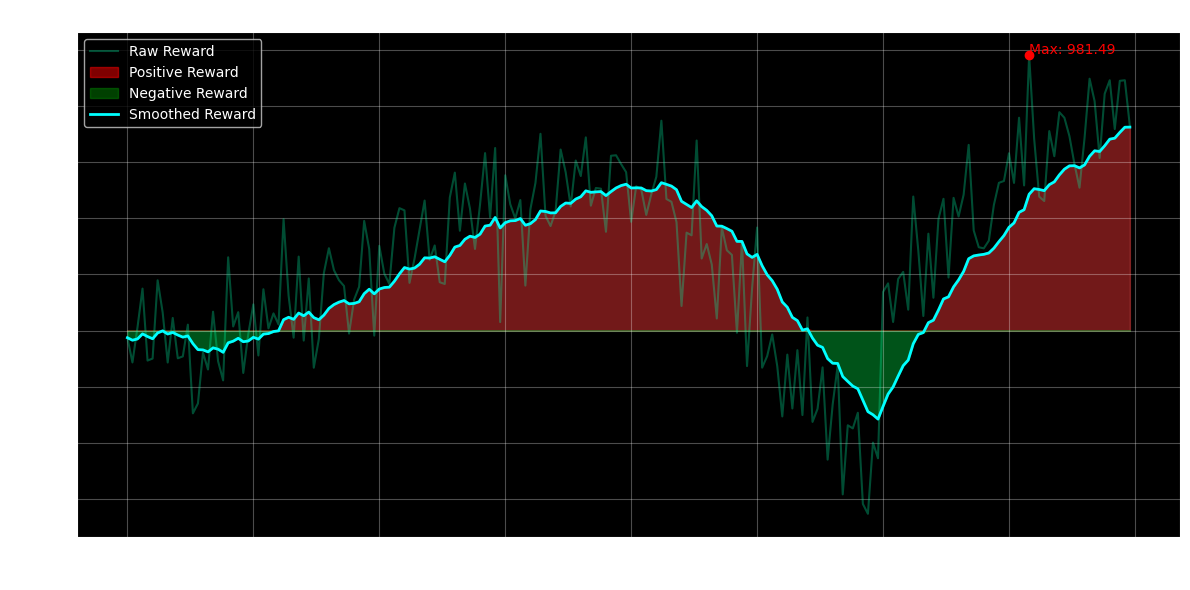

In [24]:
# ==== Test Plot ====
import numpy as np

# ==== Test Reward sequence ====
np.random.seed(42)  # For reproduce
episodes = 200
base_trend = np.concatenate([
    np.linspace(-100, 600, 100),     # Early stage
    np.linspace(600, -500, 50),       # Middle Stage
    np.linspace(100, 900, 50)        # Final Stage
])          # Slowly increase

# ==== High fluctuation ====
fluctuations = np.random.normal(0, 150, size=episodes)
rewards = base_trend + fluctuations

# ==== Call function ====
plot_training_progress(rewards)

## 主要訓練迴圈（Training Loop）

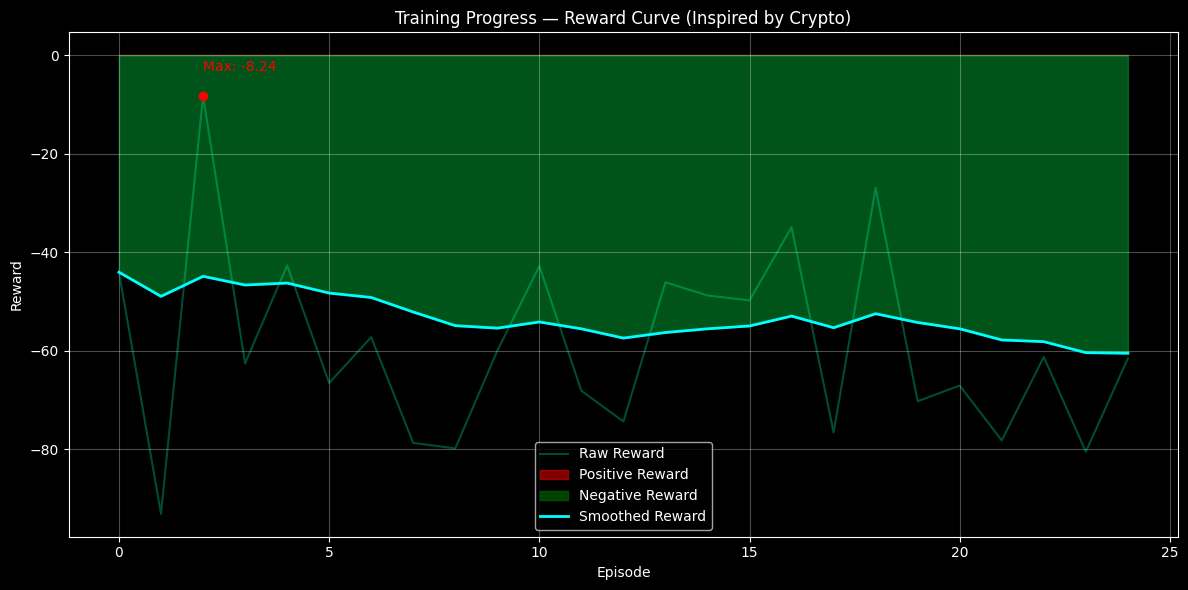

🎬 Episode 25 | 16:27:14 | Reward: -61.54 | Epsilon: 0.9486 | Domain Randomization =True | Entropy: 2.30 bits
Top actions in this episode: [(1, 61), (np.int64(0), 50), (4, 49), (3, 43), (2, 35)]


KeyboardInterrupt: 

In [25]:
# ==== Test Frame Stack by Me ====
from datetime import datetime

global memory

# ==== Build Target Network ====
model = build_model(input_shape = (96, 96, 12), action_size = 5)
target_model = build_model(input_shape=(96, 96, 12), action_size=5)
target_model.set_weights(model.get_weights())



# ==== Training Parameters ====
episodes = 3000 # More is good
batch_size = 128 # Minibatch size
gamma = 0.95 # Discount rate (~1 future is import)
max_step = 1000 # Max step per eposide
best_score = -np.inf

# ==== Before loop ====
steps = 0  # Initialize the steps

# ==== Record ====
rewards_per_episode = []


# ==== Initial memory type ====
memory = MultiStepReplayBuffer(capacity=100000, n_step=5, gamma=0.99)

# ==== Track whether switched ====
memory_switched = False

# ==== Clear memory to ensure consistent state shapes ====
# This prevents the ValueError if memory contains states from a non-stacked training run.
memory.clear()

# ===================
# ==== Training Loop ====
for episode in range(episodes):

  # ==== Switching Exploration Strategy ====

  use_epsilon = True

  # ==== Initialize Environment ====
  env = gym.make("CarRacing-v3",
               render_mode= None,
               lap_complete_percent=0.95,
               domain_randomize=True,
               continuous=False)

  # ==== Action History ====
  action_history = []

  # ==== Reset Environment ====
  state, _ = env.reset()

  # ==== Switch to prioritized buffer =====
  # Dynamic Switching Memory
  if episode == 500 and not memory_switched:
      new_memory = PrioritizedMultiStepReplayBuffer(capacity=100000, n_step=5, gamma=0.99)

      # Copy old data over (optional)
      for item in memory.buffer:
          new_memory.tree.add(1.0, item)  # set default priority
      memory = new_memory
      memory_switched = True
      print("🧠 Switched to Prioritized Replay Buffer.")

  # ==== No-op  ====
  for _ in range(50):
      state, _, terminated, truncated, _ = env.step(0)
      if terminated or truncated:
          break

  # ==== Initialize stacking: RGB version ====
  # Preprocess after no-op
  # ==== Preprocess  ====
  state = preprocess_frame(state, grayscale=False)
  frame_buffer = deque([state] * 4, maxlen=4)
  # ==== Stack State ====
  stacked_state = np.concatenate(list(frame_buffer), axis=-1)

  # ==== Episode Reward Initialize ====
  episode_reward =0.0

  # ==== Logic ====
  # state → select action → step in env → get next_state, reward → modify → store in memory

  for time in range(max_step):
    steps += 1  # Ensure epsilon dacay
    # Choose action using epsilon-greedy policy
    # act() → strategy
    # Use stacked state

    # ==== Force Forward ====
    # ==== NEW ====
    if episode < 5 and time < 100:
      # mode 1 (I recommend this one)
      action = np.random.choice([1, 2, 3])

      # mode 2
      # action = np.random.choice([1, 2, 3, 4])
    else:
      action = act(stacked_state, use_epsilon)

    action_history.append(action)

    # ===== Take action ====
    total_reward = 0

    # ==== Frame Skipping ====
    for _ in range(4):  # frame skip 次數
        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward = total_reward + reward
        if terminated or truncated:
            break

    done = terminated or truncated

    # ==== Handle Next Step ====
    if isinstance(next_state, tuple):
      next_state = next_state[0]

    next_state = preprocess_frame(next_state, grayscale=False)

    # ==== Update Stack ====
    frame_buffer.append(next_state)
    stacked_next_state = np.concatenate(list(frame_buffer), axis=-1)

    # ==== Reward Shaping ====
    reward = reward_shaping(action, total_reward, stacked_next_state, None)

    # ==== Remember ====
    # Store experience in memory
    # remember → memorize (replay buffer)
    # remember(stacked_state, action, reward, stacked_next_state, done)

    # ==== Memorize ====
    memory.store(stacked_state, action, reward, stacked_next_state, done)

    # ==== Update state ====
    stacked_state = stacked_next_state

    # ==== Record reward ====
    episode_reward = episode_reward + float(reward)

    # If episode ends
    if done:
      rewards_per_episode.append(episode_reward)

      # ====  Action Entropy ====
      action_counts = np.array([action_history.count(a) for a in range(action_size)])

      # Prevent log(0)
      action_probs = action_counts / np.sum(action_counts) + 1e-8

      action_entropy = scipy.stats.entropy(action_probs, base=2)

      # ==== Plot =====

      plot_training_progress(rewards_per_episode)

      # ==== Print ====
      print(f"🎬 Episode {episode+1} | {datetime.now().strftime('%H:%M:%S')} | Reward: {episode_reward:.2f} | Epsilon: {epsilon:.4f} | Domain Randomization ={True} | Entropy: {action_entropy:.2f} bits")
      break

  # ==== Decay Epsilon ====
  decay_epsilon(steps, episode)

  # ==== Train the model using replay memory ====

  replay_start = 5000  # Tunable
  if len(memory) > replay_start and len(memory) > batch_size:
    double_replay(batch_size, episode=episode)

  # ==== Reset Target Network ====
  if episode % 10 == 0:
    target_model.set_weights(model.get_weights())

  # ==== Update Best Score ====
  if episode_reward > best_score:
    best_score = episode_reward
    model.save('best_model.keras')
    print(f"✅ New Best Score {best_score}")

  print("Top actions in this episode:", Counter(action_history).most_common())
  print("======================================")

  # ==== Close Env ====
  env.close()


print(f"Training complete after {episodes} episodes.")
print(f"Best model score: {best_score:.2f}")



# Evaluation (Randomize = True)

In [ ]:
# Re-initialize the environment for evaluation
# Use the same parameters as the training environment

# ==== GIF file ====
output_dir = "test_real_gifs"  # Name your file
os.makedirs(output_dir, exist_ok=True)  # Create it

# ==== Evaluation ====
evaluation_episodes = 100 # Number of evaluation
score = []

# ==== Initialize Environment ====
env = gym.make("CarRacing-v3",
              render_mode= 'rgb_array',
              lap_complete_percent=0.95,
              domain_randomize=True,
              continuous=False)



for episode in range(evaluation_episodes):
  # ==== Make GIF ====
  gif_frames = []

  obs, _ = env.reset()
  frame = preprocess_frame(obs)

  # Initialize frame buffer
  frame_buffer = deque([frame]*NUM_FRAMES, maxlen=NUM_FRAMES)
  stacked_state = np.concatenate(list(frame_buffer), axis=-1)  # shape: (96, 96, 12) if RGB

  total_reward = 0


  for time in range(max_step):
    gif_frames.append(env.render())

    # Step 1: Select action
    q_values = model(stacked_state[np.newaxis, ...], training=False)[0]
    action = np.argmax(q_values)

    # Step 2: Interaction with env.
    next_obs, reward, terminated, truncated, _ = env.step(action)

    # Step 3: Preprocess frame
    next_frame = preprocess_frame(next_obs)

    # Step 4: Update frame buffer + stacked_state
    frame_buffer.append(next_frame)
    stacked_state = np.concatenate(list(frame_buffer), axis=-1)

    # Step 5: Update reward
    total_reward += float(reward)

    # Step 6: Check if done
    done = terminated or truncated
    if done:
        break

  score.append(total_reward)
  print(f"Episode: {episode+1}/{evaluation_episodes}, Score: {total_reward:.2f}")
  gif_path = os.path.join(output_dir, f"episode_{episode+1:03d}-{total_reward:.0f}.gif")
  imageio.mimsave(gif_path, gif_frames, fps=30)

env.close()

# ==== Scores ====
average_score = np.mean(score)
max_score = np.max(score)
min_score = np.min(score)
std_score = np.std(score)

print(f'Evaluation complete after {evaluation_episodes} Episodes')
print(f"Average Score: {average_score:.2f}")
print(f"Max Score: {max_score:.2f}")
print(f"Min Score: {min_score:.2f}")
print(f"Std Score: {std_score:.2f}")

# ==== Visualization ====
def smooth(data, weight=0.9):
    smoothed = []
    last = data[0]
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return np.array(smoothed)

smoothed = smooth(score)
std = np.std(score)


# ==== Use White Background ====
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'
# ==== Plot ====
plt.figure(figsize=(12, 6))

x = np.arange(len(score))

plt.plot(x, score, label='Raw Reward', alpha=0.3)

plt.plot(x, smoothed, label='Smoothed Reward', linewidth=2)

# ==== Std Band ====

plt.fill_between(x, smoothed - std, smoothed + std, alpha=0.2, color='skyblue', label='±1 Std')

# ==== Baseline ====
plt.axhline(y=500, color='red', linestyle='--', label='Pass Threshold')

# ==== Title and label ====
plt.title('Evaluation Reward Trend with Std Band')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid()
plt.show()

